In [1]:
from backbones.sana import SANA

model = SANA()
print(model)

/home/lee08/miniconda3/envs/comfyui/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
# 1) 모든 매개변수들을 먼저 변수로 설정

# # pos_text = "A serene twilight view of a traditional Korean hanok village nestled between misty mountain slopes: curved midnight-blue tiled eaves, softly glowing paper lanterns swaying in the breeze; ancient pine trees arching over stone pathways; intricate wooden lattice windows casting delicate shadows; a lone scholar in flowing hanbok practicing calligraphy beside a koi pond with lotus petals drifting on the water; cinematic 8K ultra-realism with dynamic volumetric moonlight filtering through morning mist; painterly strokes blending classical Joseon-era ink wash with modern hyperrealism; shot on RED Monstro 8K, 50 mm f/1.2 lens; subtle film grain; maximum fidelity; emotional atmosphere."
# neg_text = "lowres, bad anatomy, deformed, blurry, pixelated, oversaturated, underexposed, overexposed, artifact, jpeg artifacts, watermark, text, logo, extra limbs, mutated hands, unnatural colors, noisy background, out of focus, poor composition, cultural clichés, stereotype exaggeration, flat lighting, glitch"
pos_text =  "a beautiful cat with a girl and a dog"
neg_text = "ugly, blurry, low quality"

guidance_scale = 4.5
num_steps = 10
seed = 42
steps = 10
flow_shift = 3.0
# collector = StateCollector()  #중간 상태 확인 - 주의 : samplaer 실행마다 다른이름으로 만들기기

# 2) 모델 함수 생성 
model_fn, noise_schedule, latents = model.get_model_fn(pos_text=pos_text, neg_text=neg_text, guidance_scale=guidance_scale, num_steps=num_steps, seed=seed)


In [3]:
from solvers.heun_solver import Heun_Solver
from solvers.common_lee import *

# 3) -> Sovler 생성 -> 샘플링
solver = Heun_Solver(model_fn, noise_schedule)
collector_heun = StateCollector()  #중간 상태 확인
final_latents = solver.sample(latents, steps=steps, skip_type='time_uniform_flow', flow_shift=flow_shift, callback=collector_heun)

# 4) 중간 상태 확인
print("Intermediate steps:", len(collector_heun.states))

# 5) 후처리
pixel_samples = model.decode_vae(final_latents)
heun_sample = pixel_samples[0]

Intermediate steps: 10


In [4]:
# ── Quick Inspection Cell ──
# 1) Latents
print(f"latents: type={type(latents)}, shape={latents.shape}")

# 2) Decoded samples (always a list)
print(f"pixel_samples: type={type(pixel_samples)}, length={len(pixel_samples)}")
print(f" first sample size: {pixel_samples[0].size}")


latents: type=<class 'torch.Tensor'>, shape=torch.Size([1, 32, 32, 32])
pixel_samples: type=<class 'list'>, length=1
 first sample size: (1024, 1024)


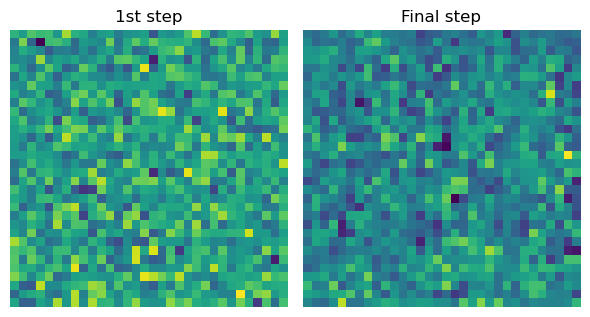

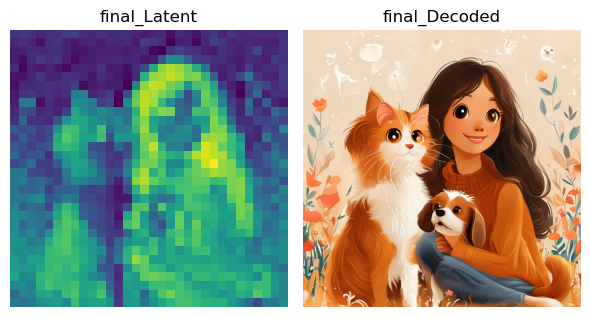

In [5]:
ch = 24 # Latent 의  24번째 채널만 확인

# 5) latent vs latent 결과 비교 시각화
show_latent_compare(collector_heun.states[0], collector_heun.states[-1],
                    name1="1st step", name2="Final step",channel=ch)

# 5) latent vs decoded 결과 비교 시각화
show_latent_vs_decoded(final_latents, heun_sample,
                       name1="final_Latent", name2="final_Decoded",channel=ch)

# decoded vs decoded
# show_decoded_compare(decoded1, decoded2,
#                      name1="Euler Decoded", name2="Heun Decoded")


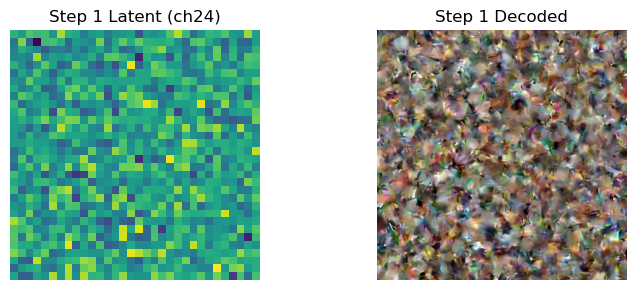

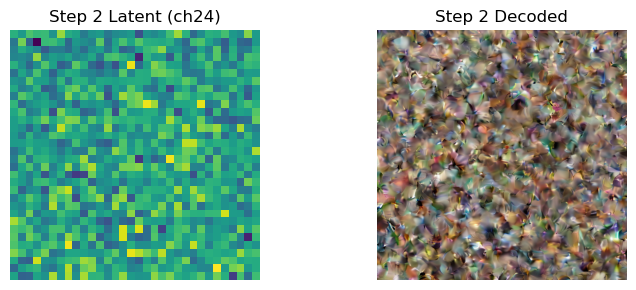

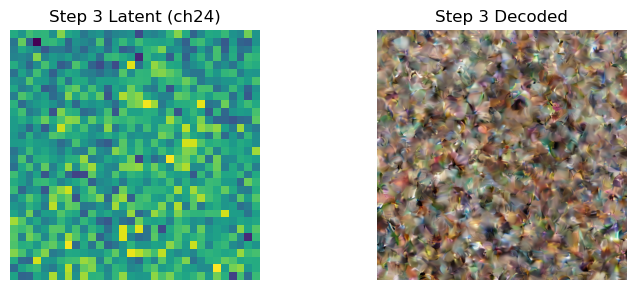

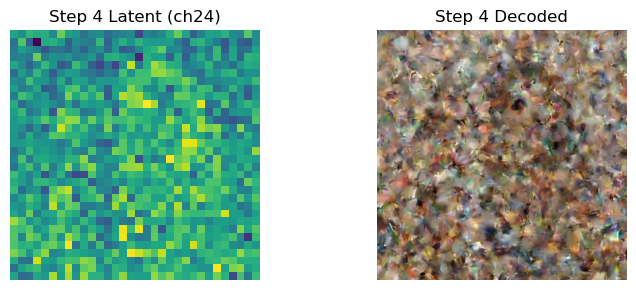

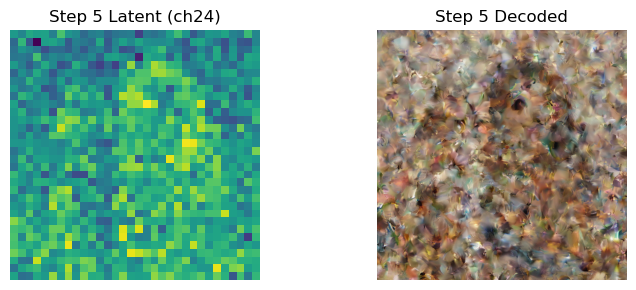

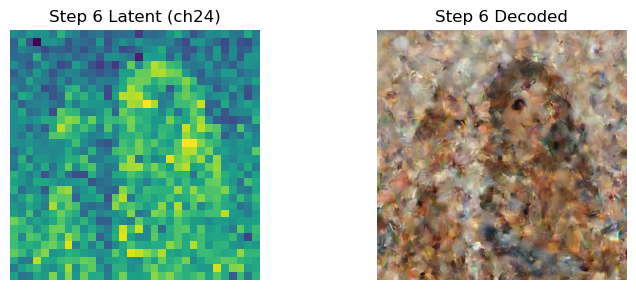

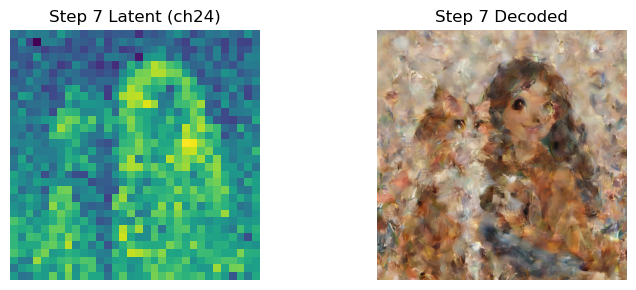

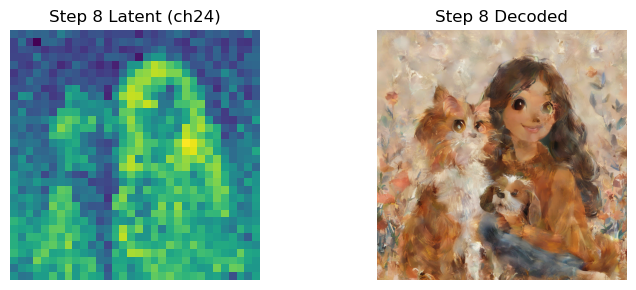

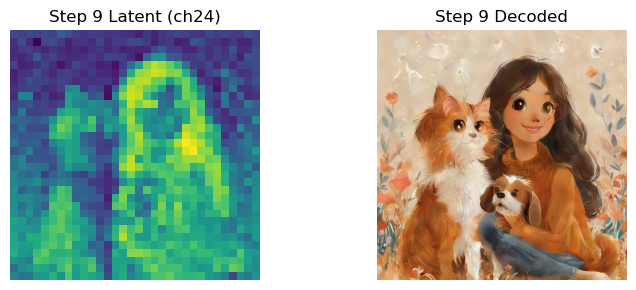

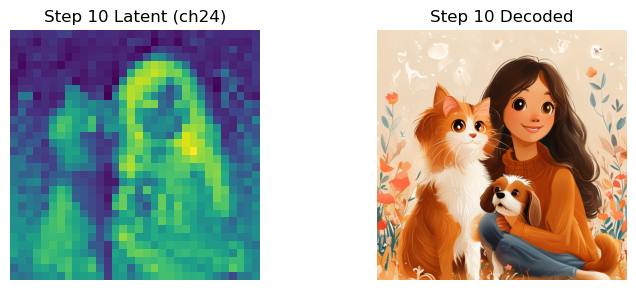

In [6]:
visualize_intermediate_results(
    collector_heun.states,
    model.decode_vae,
    channel=24
)

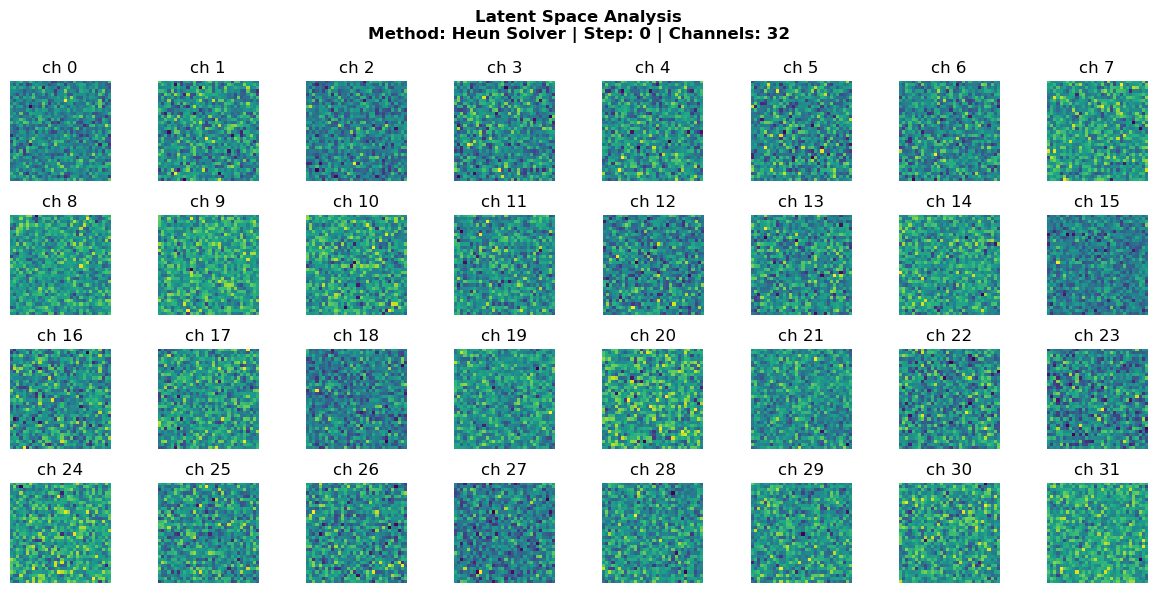

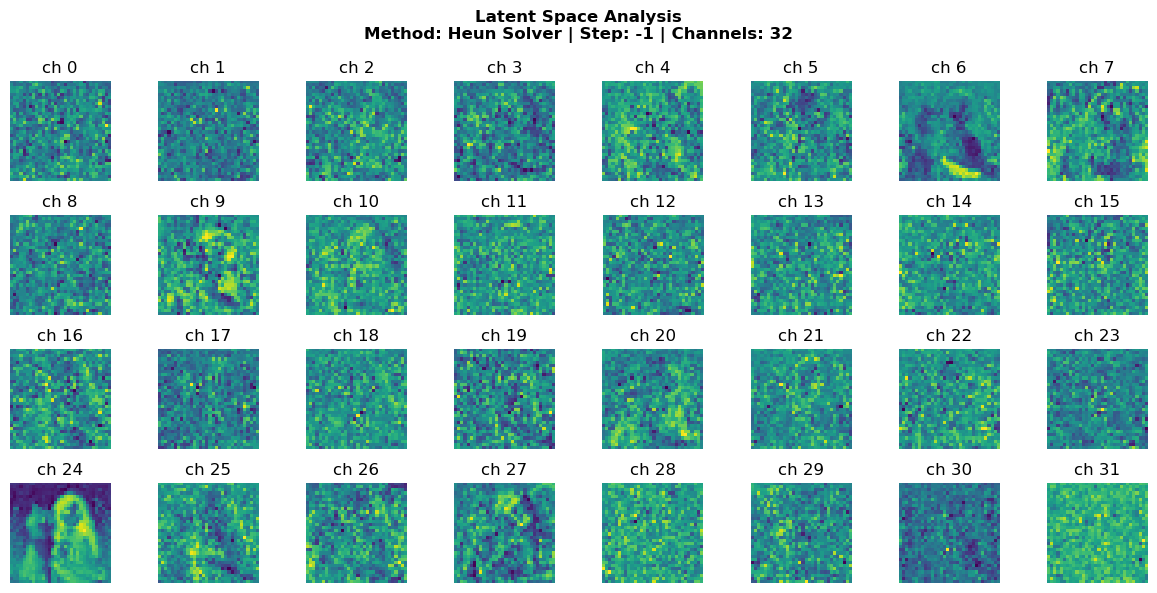

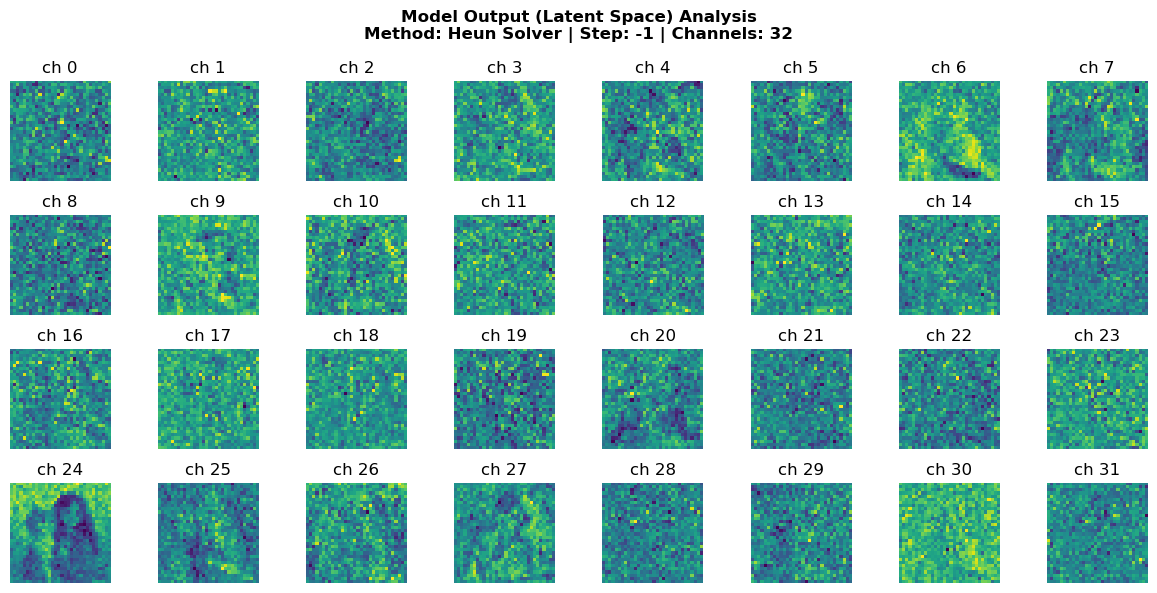

In [7]:
import matplotlib.pyplot as plt
import torch

n_ch = 32  # latent의 32개 채널 모두 확인하기
t0 = 0
t1 = -1

latent = collector_heun.states[t0].squeeze(0)
if latent.dtype == torch.bfloat16:
    latent = latent.to(torch.float32)

fig, axes = plt.subplots(4, 8, figsize=(12,6))
# 실험 정보 포함
fig.suptitle(f'Latent Space Analysis\n'
             f'Method: Heun Solver | Step: {t0} | Channels: {n_ch}',
             #f'Shape: {latent.shape} | dtype: {latent.dtype}', 
             fontsize=12, fontweight='bold')
for i in range(n_ch):
    ax = axes.flat[i]
    img = latent[i].cpu().numpy()
    ax.imshow(img, cmap='viridis')
    ax.set_title(f"ch {i}")
    ax.axis('off')
plt.tight_layout()
plt.show()

latent = collector_heun.states[t1].squeeze(0)
if latent.dtype == torch.bfloat16:
    latent = latent.to(torch.float32)

fig, axes = plt.subplots(4, 8, figsize=(12,6))
# 실험 정보 포함
fig.suptitle(f'Latent Space Analysis\n'
             f'Method: Heun Solver | Step: {t1} | Channels: {n_ch}',
             #f'Shape: {latent.shape} | dtype: {latent.dtype}', 
             fontsize=12, fontweight='bold')
for i in range(n_ch):
    ax = axes.flat[i]
    img = latent[i].cpu().numpy()
    ax.imshow(img, cmap='viridis')
    ax.set_title(f"ch {i}")
    ax.axis('off')
plt.tight_layout()
plt.show()


denoised = collector_heun.denoised[t1].squeeze(0)
if denoised.dtype == torch.bfloat16:
    denoised = denoised.to(torch.float32)

fig, axes = plt.subplots(4, 8, figsize=(12,6))
# 실험 정보 포함
fig.suptitle(f'Model Output (Latent Space) Analysis\n'
             f'Method: Heun Solver | Step: {t1} | Channels: {n_ch}',
             #f'Shape: {latent.shape} | dtype: {latent.dtype}', 
             fontsize=12, fontweight='bold')
for i in range(n_ch):
    ax = axes.flat[i]
    img = denoised[i].cpu().numpy()
    ax.imshow(img, cmap='viridis')
    ax.set_title(f"ch {i}")
    ax.axis('off')
plt.tight_layout()
plt.show()


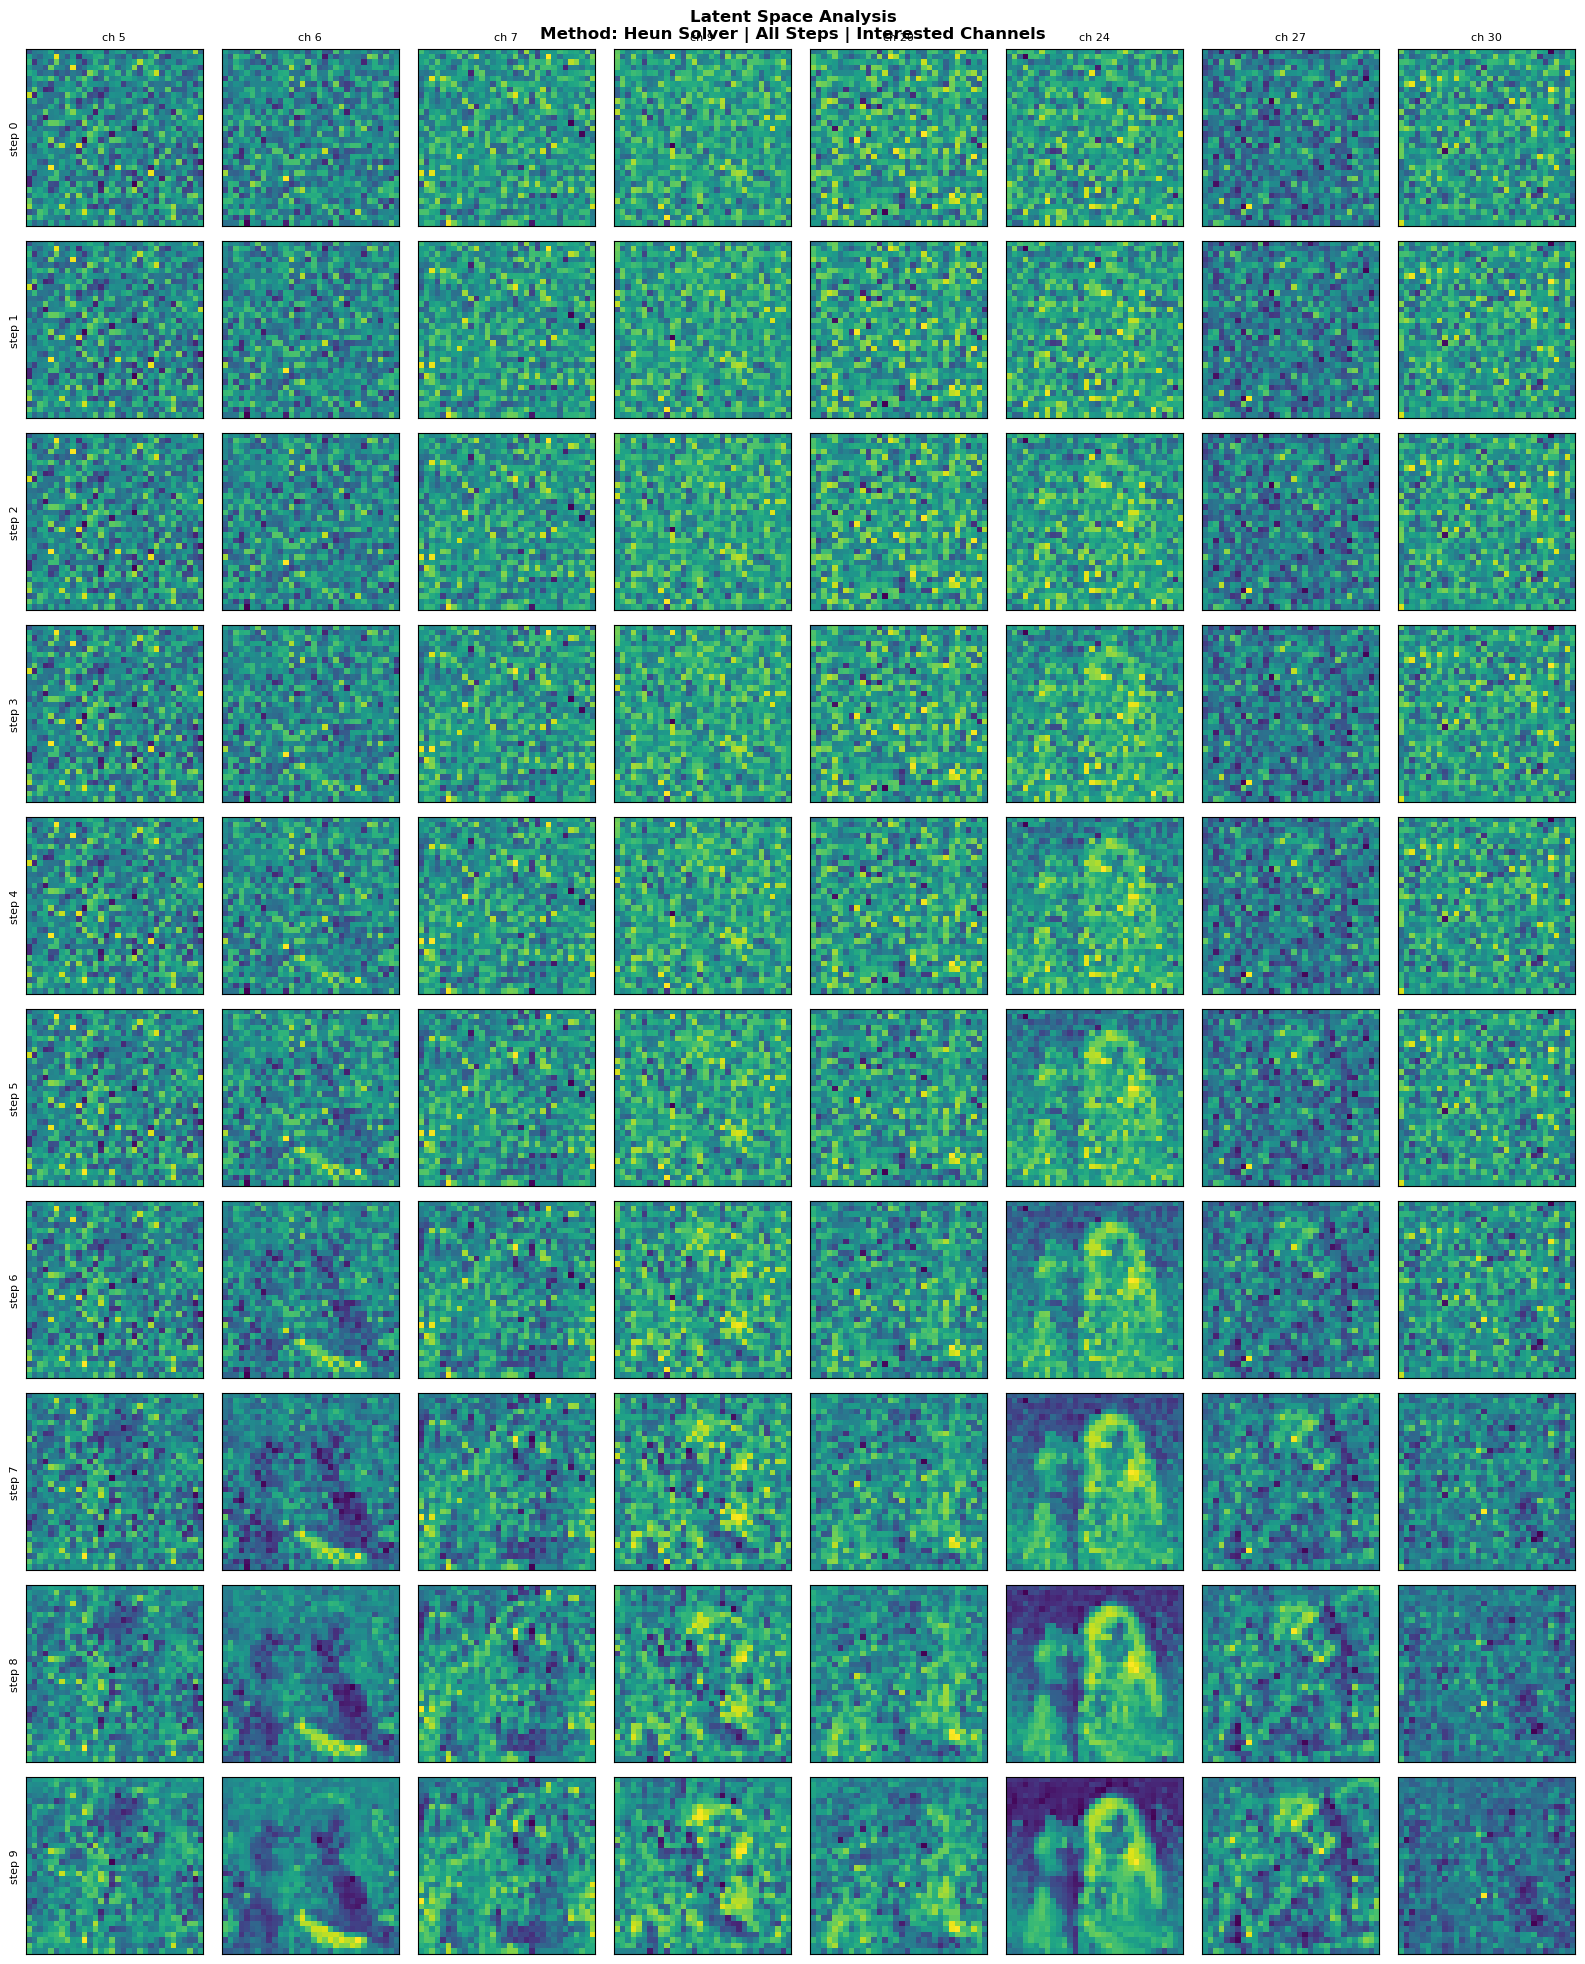

In [ ]:
import matplotlib.pyplot as plt
import torch

# 전체 step에서, 보고 싶은 채널 리스트의 변화 보기기
n_steps = len(collector_heun.states)  # 실제 수집된 스텝 수
channels = [5,6,7,9,20,24,27,30]      # 보고 싶은 특정 채널 인덱스

# 배치 차원 제거 + bfloat16 → float32 캐스트
def get_channel_image(state, ch):
    lt = state.squeeze(0)           # [C, H, W]
    if lt.dtype == torch.bfloat16:
        lt = lt.to(torch.float32)
    img = lt[ch].cpu().numpy()      # [H, W]
    return img

# 1) n_steps × len(channels) 그리드 생성
fig, axes = plt.subplots(n_steps, len(channels), 
                         figsize=(2*len(channels), 2*n_steps),
                         squeeze=False)
# 실험 정보 포함
fig.suptitle(f'Latent Space Analysis\n'
             f'Method: Heun Solver | All Steps | Interested Channels\n',
             #f'Shape: {latent.shape} | dtype: {latent.dtype}', 
             fontsize=12, fontweight='bold')
# 2) 각 셀에 이미지 플롯
for i in range(n_steps):
    for j, ch in enumerate(channels):
        ax = axes[i][j]
        img = get_channel_image(collector_heun.states[i], ch)
        ax.imshow(img, cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])
        # 타이틀: 첫 행엔 채널 번호, 첫 열엔 스텝 번호
        if i == 0:
            ax.set_title(f"ch {ch}", fontsize=8)
        if j == 0:
            ax.set_ylabel(f"step {i}", fontsize=8)
        
plt.tight_layout()
plt.show()


In [ ]:
#새로운 실험험

In [ ]:

pos_text =  "a beautiful landscape with mountains and lake, masterpiece, high quality"
neg_text = "ugly, blurry, low quality"
# 1) 모든 매개변수들을 먼저 변수로 설정
guidance_scale = 4.5
num_steps = 10
seed = 42
steps = 30
flow_shift=3.0

collector_euler = StateCollector()  #중간 상태 확인
solver_1 = Euler_Solver(model_fn, noise_schedule)
latent_samples = solver_1.sample(latents, steps=steps, skip_type='time_uniform_flow', flow_shift=flow_shift, callback=collector_euler)
pixel_samples = model.decode_vae(latent_samples)
euler_sample = pixel_samples[0]

collector_heun = StateCollector()  #중간 상태 확인
solver_2 = Heun_Solver(model_fn, noise_schedule)
latent_samples = solver_2.sample(latents, steps=steps, skip_type='time_uniform_flow', flow_shift=flow_shift, callback=collector_heun)
pixel_samples = model.decode_vae(latent_samples)
heun_sample = pixel_samples[0]

solver_3 = DPM_Solver(model_fn, noise_schedule)
latent_samples = solver_3.sample(latents, steps=steps, skip_type='time_uniform_flow', flow_shift=flow_shift)
pixel_samples = model.decode_vae(latent_samples)
dpm_solver_sample = pixel_samples[0]

#decoded vs decoded vs decoded

show_three_decoded_compare(
    euler_sample,
    heun_sample,
    dpm_solver_sample,
    name1="Euler",
    name2="Heun",
    name3="DPM",
    figsize=(15, 5)
)